In [3]:
using Plots, PlotThemes, ColorSchemes
using Statistics, Distributions
using MAT
using LinearAlgebra, ToeplitzMatrices
using FFTW
using SplitApplyCombine

theme(:juno)
default(fontfamily="times", size=(1200,600), palette=:seaborn_deep6, linewidth=2)

## Laboratorio de Filtros Kalman

Se cuenta con los datos de posición en coordenadas cartesianas $x,\,y,\,z$ de la trayectoria de un cohete sonda importados del archivo `dat_gps_vs30.mat`. Los datos están expresados en metros y son medidos con un intervalo de muestreo de $T = 1\,\text s$

In [4]:
x = matread("Data/dat_gps_vs30.mat")["pos_e"]
T = 1;

Los datos se van a analizar con un filtro de Kalman vectorial
$$\begin{aligned}
    \mathbf y[n] &= \mathbf A \mathbf y[n-1] + \mathbf I \mathbf \eta[n]\\[1em]
    \mathbf x[n] &= \mathbf H \mathbf y[n] + \nu[n]
\end{aligned}
    \qquad\text{con}\qquad
\mathbf y [n] = \begin{bmatrix}\mathbf x [n]\\[0.5em] \mathbf v[n]\\[0.5em] \mathbf a[n]\end{bmatrix} \in \mathbb R^{3\times1}
$$
Donde la matriz $\mathbf A$ es una matriz de Toeplitz triangular superior y la matriz $\mathbf H$ una matriz diagonal aumentada, definidas de la siguiente forma
$$
\mathbf A = \begin{bmatrix}
    \mathbf I_{3\times3} &     T\mathbf I_{3\times3} &    \frac{T^2}{2} \mathbf I_{3\times3}\\[0.5em]
    \mathbf 0_{3\times3} &     \mathbf I_{3\times3} &     T \mathbf I_{3\times3}\\[0.5em]
    \mathbf 0_{3\times3} &     \mathbf 0_{3\times3} &     \mathbf I_{3\times3}\\
\end{bmatrix} \in \mathbb R^{9\times9}
\qquad
\mathbf H = \begin{bmatrix}
    \mathbf I_{3\times3} &     \mathbf 0_{3\times3} &    \mathbf 0_{3\times3}\\
\end{bmatrix}\in \mathbb R^{3\times9}
$$

In [5]:
A = TriangularToeplitz([1 0 0 T 0 0 T^2/2 0 0], :U)
H = [I zeros(3, 6)];

El ruido de modelo es definido como $\mathbf \eta[n] \in \mathbb R^{9\times1}$ con correlación $C_\eta$ y el de ruido de medición como $\mathbf \nu[n] \in \mathbb R^{3\times1}$ con correlación $C_\nu$.

En función de esto definimos el filtro de Kalman

In [6]:
function kalman_vec(x; C_v, C_η, A, B, H, y0, M0)
    K = Matrix{Float64}[]
    y = Vector{Float64}[]
    M = Matrix{Float64}[]

    y_pred = A*y0
    M_pred = A*M0*A'+B*C_η*B'
    push!(K, M_pred*H'*inv(C_v+H*M_pred*H'))
    push!(y, y_pred + K[1]*(x[1,:].-H*y_pred))
    push!(M, (I-K[1]*H)*M_pred)
    
    for i = 2:size(x)[1]
        y_pred = A*y[i-1]
        M_pred = A*M[i-1]*A'+B*C_η*B'
        push!(K, M_pred*H'*inv(C_v+H*M_pred*H'))
        push!(y, y_pred + K[i]*(x[i,:].-H*y_pred))
        push!(M, (I-K[i]*H)*M_pred)
    end
    return [y, M, K]
end

kalman_vec (generic function with 1 method)

### Análisis Preliminar de los Datos

En primera instancia, se pueden visualizar los datos obteniendo la velocidad y aceleración con una derivada numérica. 

Esto permitirá saber si el resultado del filtro de Kalman es el esperado, y además permitirá obtener valores razonables para los parámetros del filtro, $C_\nu$, $C_\eta$, así como las estmaciones iniciales de $\mathbf y[0]$ y su error $\mathbf M[0]$.

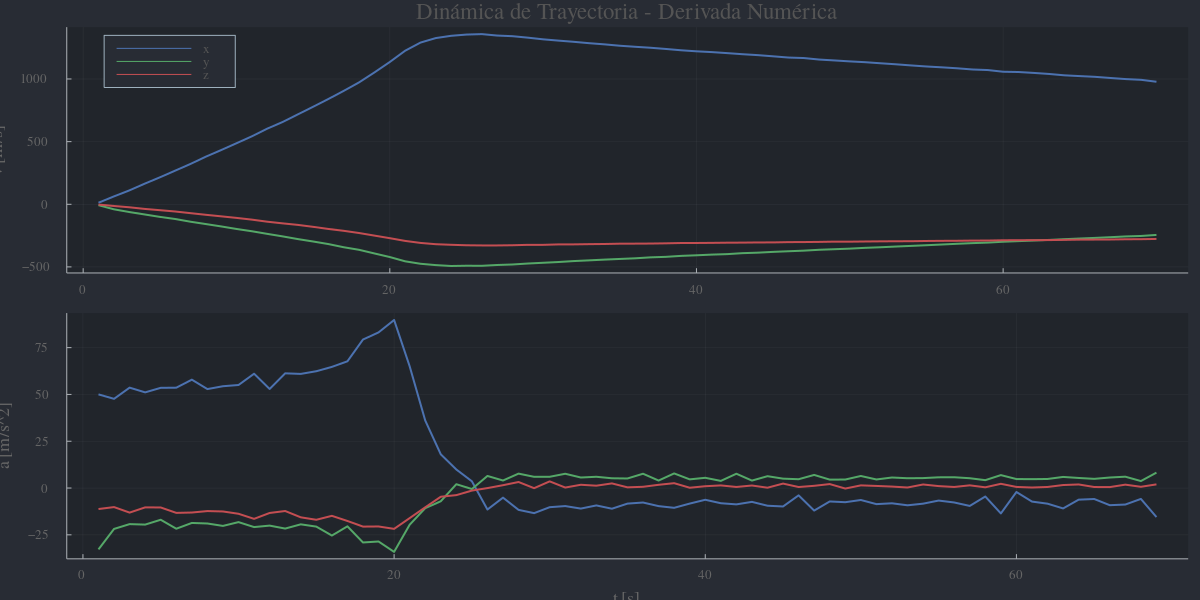

In [7]:
v = diff(x,dims=1)
a = diff(v,dims=1)

p2 = plot(v, ylabel="v [m/s]", label=["x" "y" "z"], legend=:topleft, title="Dinámica de Trayectoria - Derivada Numérica")
p3 = plot(a, ylabel="a [m/s^2]", xlabel = "t [s]", legend=false)
plot(p2, p3, layout=(2,1))

Es razonable suponer en función de estos datos un ruido de modelo no-correlacionado, en donde la varianza $\sigma_{\eta ii}^2$ es:
- Para $\mathbf x$: Máxima excursión de la velocidad
- Para $\mathbf v$: Máxima excursión de la aceleración
- Para $\mathbf a$: Máxima excursión de la derivada numérica de la aceleración

In [8]:
Var_x = v[:,1] |> maximum;
Var_v = a[:,1] |> maximum;
Var_a = diff(a[:,1],dims=1) |> maximum;
C_η=diagm([Var_x.*ones(3); Var_v.*ones(3); Var_a.*ones(3)]);

Para la condición inicial, tomamos la primer medición registrada de $\mathbf x$ y los primeros valores para $\mathbf v$ y $\mathbf a$ obtenidos a partir de la derivada numérica.

Consideramos el error de esta estimación igual al error del modelo $\sigma_\eta^2$

In [9]:
y0 = [x[1,:]; v[1,:]; a[1,:]]
M0 = C_η;

Se desconoce el ruido de medición, pero observando las mediciones de $\mathbf x$ podemos hacer una suposición razonable. Las mediciones no se ven ruidosas, incluso en su derivada numérica que amplificaría el ruido de alta frecuencia. Es argumento para usar un ruido de medición $\sigma_\nu^2$ chico.

In [10]:
C_v = diagm(1 .*ones(3));

### Aplicación del Filtro de Kalman

Con los parámetros definidos aplicamos el filtro de Kalman y observamos los resultados en sus componentes $x,\, y,\, z$.

In [11]:
params = (C_v=C_v, C_η=C_η, A=A, B=I, H=H, y0=y0, M0=C_η)
y, M, K = kalman_vec(x; params...);

In [12]:
ys = invert(y)
vars = invert(diag.(M))
ys_max = [ys[i] .+ sqrt.(abs.(vars[i])) for i in 1:9]
ys_min = [ys[i] .- sqrt.(abs.(vars[i])) for i in 1:9];

xs = ys[1:3]
vs = ys[4:6]
as = ys[7:9];

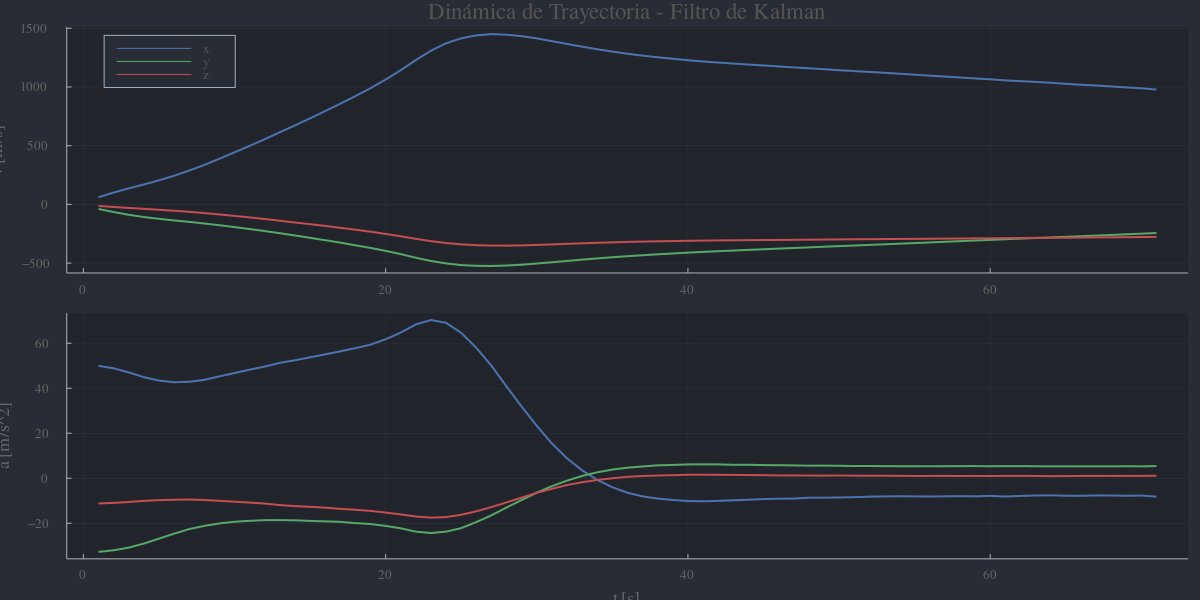

In [14]:
p2 = plot(vs, ylabel="v [m/s]", label=["x" "y" "z"], legend=:topleft, title="Dinámica de Trayectoria - Filtro de Kalman")
p3 = plot(as, ylabel="a [m/s^2]", xlabel = "t [s]", legend=false)
plot(p2, p3, layout=(2,1))

Finalmente observamos la dinámica de la trayectoria en módulo. 

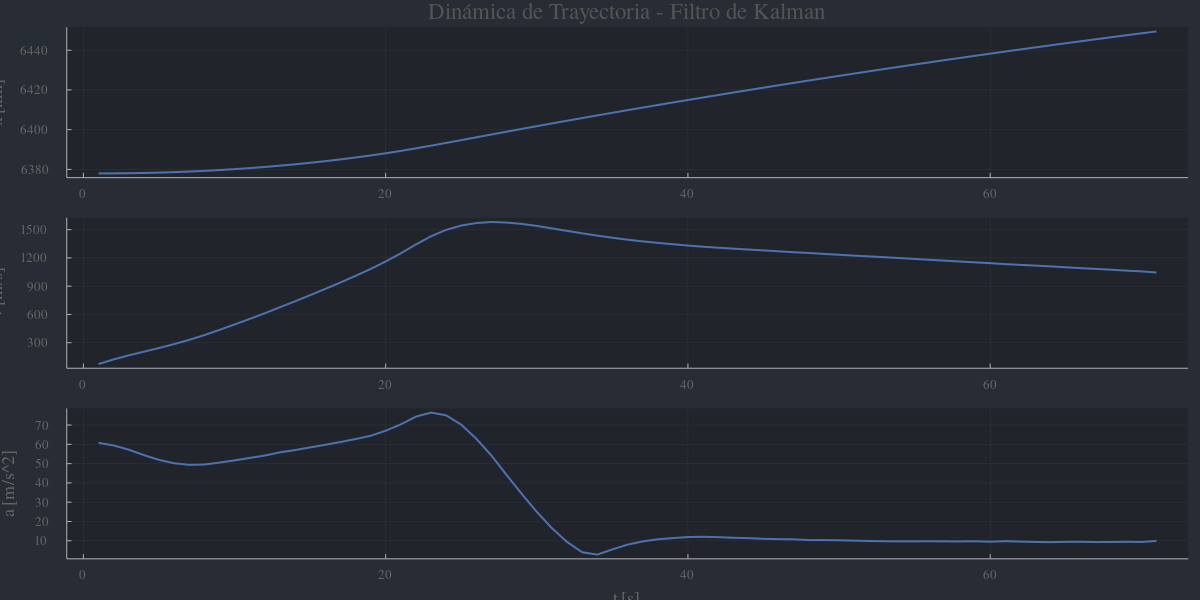

In [16]:
x_mod = [hypot(x...) for x in invert(xs)]
v_mod = [hypot(v...) for v in invert(vs)]
a_mod = [hypot(a...) for a in invert(as)]
p1 = plot(x_mod./1e3, ylabel="x [km]", title="Dinámica de Trayectoria - Filtro de Kalman")
p2 = plot(v_mod, ylabel="v [m/s]")
p3 = plot(a_mod, ylabel="a [m/s^2]", xlabel="t [s]")
plot(p1, p2, p3, layout=(3,1), legend=false)